In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
from src.utils.metrics import obtener_ruta_app

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


In [4]:
def cargar_y_preparar_datos(archivo_csv=None, data_string=None):
    """
    Carga y prepara los datos desde CSV o string
    """
    print("=== CARGANDO DATOS ===")

    if data_string:
        # Si se proporciona data como string (para testing)
        from io import StringIO
        df = pd.read_csv(StringIO(data_string), header=None)
        df.columns = ['produccion', 'area', 'PRECTOTCORR_SUM', 'RH2M', 'T2M',
                     'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'WS2M', 'fecha', 'canton_id']
    else:
        df = pd.read_csv(archivo_csv)

    # Convertir fecha
    df['fecha'] = pd.to_datetime(df['fecha'])
    df = df.sort_values('fecha')

    # Filtrar datos: mantener solo desde 2009 en adelante
    df = df[df['fecha'].dt.year > 2011]
    print(f"Datos filtrados desde 2009: {df.shape}")

    # Rellenar valores nulos
    columnas_numericas = ['produccion', 'area', 'PRECTOTCORR_SUM', 'RH2M', 'T2M',
                         'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'WS2M']

    for col in columnas_numericas:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    # Agregar características temporales
    df['mes'] = df['fecha'].dt.month
    df['año'] = df['fecha'].dt.year

    print(f"Datos cargados: {df.shape}")
    print(f"Rango fechas: {df['fecha'].min()} a {df['fecha'].max()}")

    return df

def grafico_exploratorio_simple(df):
    """
    Gráfico simple de exploración
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(df['fecha'], df['produccion'], linewidth=1, color='blue')
    plt.title('Producción en el Tiempo')
    plt.xlabel('Fecha')
    plt.ylabel('Producción')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.hist(df['produccion'], bins=20, color='green', alpha=0.7)
    plt.title('Distribución Producción')
    plt.xlabel('Producción')
    plt.ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()

=== CARGANDO DATOS ===
Datos filtrados desde 2009: (810, 12)
Datos cargados: (810, 14)
Rango fechas: 2012-01-01 00:00:00 a 2025-06-01 00:00:00


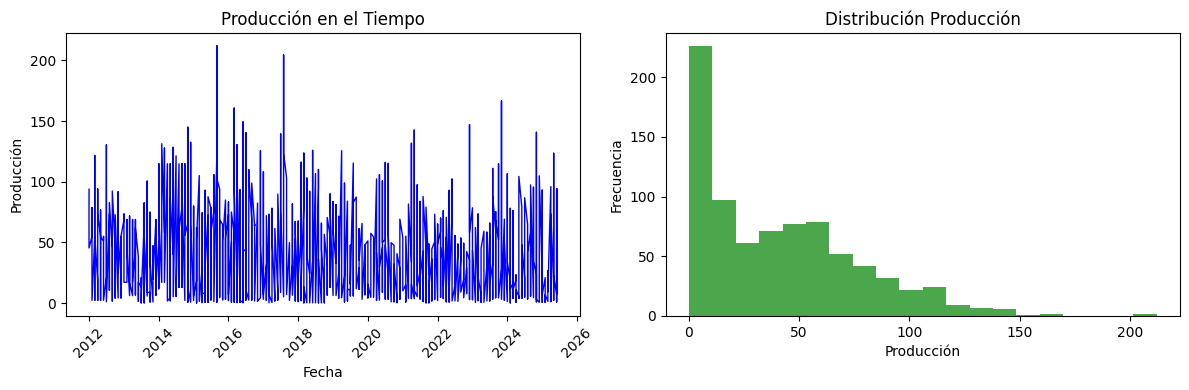

In [5]:
df = cargar_y_preparar_datos("C:/TemplateAgroIA/data/rnn_produccion.csv")
grafico_exploratorio_simple(df)

In [6]:
def preparar_datos_lstm(df, ventana_tiempo=3):
    """
    Prepara datos para LSTM
    """
    print(f"\n=== PREPARANDO DATOS LSTM ===")
    print(f"Ventana temporal: {ventana_tiempo} meses")

    # Características a usar
    columnas_features = ['area', 'PRECTOTCORR_SUM', 'RH2M', 'T2M', 'T2MDEW',
                        'T2MWET', 'T2M_MAX', 'T2M_MIN', 'WS2M', 'mes']
    columna_target = 'produccion'

    # Preparar datos
    data = df[columnas_features + [columna_target]].values

    # Normalizar
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # Crear secuencias
    X, y = [], []
    for i in range(ventana_tiempo, len(data_scaled)):
        X.append(data_scaled[i-ventana_tiempo:i, :-1])  # Features
        y.append(data_scaled[i, -1])  # Target

    X, y = np.array(X), np.array(y)

    # Dividir datos
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    print(f"Entrenamiento: {X_train.shape}")
    print(f"Prueba: {X_test.shape}")

    return X_train, X_test, y_train, y_test, scaler, columnas_features


In [7]:
 X_train, X_test, y_train, y_test, scaler, columnas_features = preparar_datos_lstm(df)


=== PREPARANDO DATOS LSTM ===
Ventana temporal: 3 meses
Entrenamiento: (645, 3, 10)
Prueba: (162, 3, 10)


In [8]:
def crear_modelo_lstm(input_shape):
    """
    Crea un modelo LSTM optimizado para mejor rendimiento y regularización.
    """
    print("\n=== CREANDO MODELO LSTM MEJORADO ===")

    model = Sequential([
        LSTM(64,
             return_sequences=True,
             input_shape=input_shape,
             activation='tanh',
             kernel_initializer='glorot_uniform',
             recurrent_initializer='orthogonal',
             kernel_regularizer=tf.keras.regularizers.l2(0.0003),
             recurrent_regularizer=tf.keras.regularizers.l2(0.0003)),
        Dropout(0.3),

        LSTM(32,
             return_sequences=False,
             activation='tanh',
             kernel_initializer='glorot_uniform',
             recurrent_initializer='orthogonal',
             kernel_regularizer=tf.keras.regularizers.l2(0.0003),
             recurrent_regularizer=tf.keras.regularizers.l2(0.0003)),
        Dropout(0.3),

        Dense(32, activation='relu'),  # Aumenté un poco la capa densa
        Dropout(0.2),  # Dropout adicional antes de la salida

        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0),  # LR ligeramente menor
        loss='mse',
        metrics=['mae']
    )

    print(f"Modelo creado con {model.count_params():,} parámetros.")
    return model


def entrenar_modelo(model, X_train, y_train, X_val, y_val):
    """
    Entrena el modelo con callbacks para early stopping y reducción de tasa de aprendizaje.
    """
    print("\n=== ENTRENANDO MODELO MEJORADO ===")

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=30,  # Reduce paciencia para no esperar demasiado
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Reduce la tasa de aprendizaje más agresivamente
        patience=10,
        min_lr=1e-6,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=32,  # Ajustado a un tamaño de batch más estándar
        callbacks=[early_stopping, reduce_lr],
        verbose=1,
        shuffle=True
    )

    return history

In [9]:
 # 3. Crear y entrenar modelo
model = crear_modelo_lstm((X_train.shape[1], X_train.shape[2]))
history = entrenar_modelo(model, X_train, y_train, X_test, y_test)



=== CREANDO MODELO LSTM MEJORADO ===
Modelo creado con 32,705 parámetros.

=== ENTRENANDO MODELO MEJORADO ===
Epoch 1/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1234 - mae: 0.1918 - val_loss: 0.0776 - val_mae: 0.1291 - learning_rate: 5.0000e-04
Epoch 2/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0872 - mae: 0.1505 - val_loss: 0.0718 - val_mae: 0.1402 - learning_rate: 5.0000e-04
Epoch 3/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0760 - mae: 0.1486 - val_loss: 0.0642 - val_mae: 0.1339 - learning_rate: 5.0000e-04
Epoch 4/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0708 - mae: 0.1481 - val_loss: 0.0595 - val_mae: 0.1368 - learning_rate: 5.0000e-04
Epoch 5/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0653 - mae: 0.1498 - val_loss: 0.0548 - val_mae: 0.1344 - learning_rate: 5.0000e-04
Epoch 6/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0621 - mae: 0.1475 - val_loss: 0.0518 - val_mae: 0.1388 - learning_rate: 5.0000e-04
Epoch 7/300
21/21 

In [10]:
def evaluar_modelo(model, X_test, y_test, scaler):
    """
    Evalúa el modelo
    """
    print(f"\n=== EVALUANDO MODELO ===")

    # Predicciones
    y_pred = model.predict(X_test, verbose=0)

    # Desnormalizar
    n_features = scaler.n_features_in_
    target_idx = n_features - 1

    # Crear arrays temporales para desnormalizar
    temp_test = np.zeros((len(y_test), n_features))
    temp_test[:, target_idx] = y_test
    y_test_real = scaler.inverse_transform(temp_test)[:, target_idx]

    temp_pred = np.zeros((len(y_pred), n_features))
    temp_pred[:, target_idx] = y_pred.flatten()
    y_pred_real = scaler.inverse_transform(temp_pred)[:, target_idx]

    # Métricas
    mse = mean_squared_error(y_test_real, y_pred_real)
    mae = mean_absolute_error(y_test_real, y_pred_real)
    r2 = r2_score(y_test_real, y_pred_real)
    rmse = np.sqrt(mse)

    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    return y_test_real, y_pred_real

def graficos_evaluacion_simples(history, y_test_real, y_pred_real):
    """
    Gráficos simples de evaluación
    """
    plt.figure(figsize=(15, 4))

    # Pérdida
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Entrenamiento', color='blue')
    plt.plot(history.history['val_loss'], label='Validación', color='red')
    plt.title('Pérdida del Modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)


=== EVALUANDO MODELO ===
MSE: 1243.6368
RMSE: 35.2652
MAE: 29.1249
R²: -0.0241


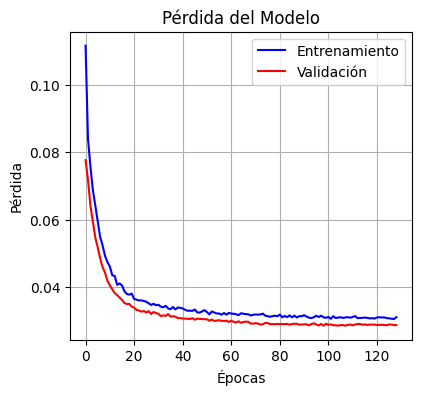

In [11]:
 # 4. Evaluar
y_test_real, y_pred_real = evaluar_modelo(model, X_test, y_test, scaler)
graficos_evaluacion_simples(history, y_test_real, y_pred_real)


In [12]:
def predecir_futuro(model, X_test, scaler, meses_futuro=6):
    """
    Predice valores futuros
    """
    print(f"\n=== PREDICIENDO {meses_futuro} MESES FUTUROS ===")

    # Última secuencia
    ultima_secuencia = X_test[-1].copy()
    predicciones = []

    for i in range(meses_futuro):
        # Predicción
        pred = model.predict(ultima_secuencia.reshape(1, *ultima_secuencia.shape), verbose=0)
        predicciones.append(pred[0, 0])

        # Actualizar secuencia
        nueva_fila = ultima_secuencia[-1].copy()
        nueva_fila[-1] = pred[0, 0]  # Actualizar mes (última característica)
        ultima_secuencia = np.vstack([ultima_secuencia[1:], nueva_fila])

    # Desnormalizar
    n_features = scaler.n_features_in_
    target_idx = n_features - 1

    temp_pred = np.zeros((len(predicciones), n_features))
    temp_pred[:, target_idx] = predicciones
    predicciones_reales = scaler.inverse_transform(temp_pred)[:, target_idx]

    return predicciones_reales

def grafico_predicciones_simples(df, predicciones_futuras, meses_futuro=6):
    """
    Gráfico simple de predicciones futuras
    """
    # Fechas futuras
    ultima_fecha = df['fecha'].max()
    fechas_futuras = pd.date_range(start=ultima_fecha + pd.DateOffset(months=1),
                                  periods=meses_futuro, freq='M')
    # Valores numéricos
    print(f"\nPredicciones próximos {meses_futuro} meses:")
    for i, (fecha, pred) in enumerate(zip(fechas_futuras, predicciones_futuras)):
        print(f"  {fecha.strftime('%Y-%m')}: {pred:.2f}")


In [13]:
predicciones_futuras = predecir_futuro(model, X_test, scaler, meses_futuro=6)
grafico_predicciones_simples(df, predicciones_futuras)


=== PREDICIENDO 6 MESES FUTUROS ===

Predicciones próximos 6 meses:
  2025-07: 38.90
  2025-08: 44.84
  2025-09: 50.98
  2025-10: 50.82
  2025-11: 50.85
  2025-12: 50.88


In [14]:
base_path = obtener_ruta_app("TemplateAgroIA")
assert base_path is not None, "base_path es None, verificar función obtener_ruta_app"
model_path = os.path.join(base_path, "models", "modelo_RNN_Papas.h5")
print("Model path:", model_path)
# Guarda el modelo
model.save(model_path)
print("Modelo guardado con éxito.")


Model path: C:\TemplateAgroIA\models\modelo_RNN_Papas.h5
Modelo guardado con éxito.
